<!-- PELICAN_BEGIN_SUMMARY -->

In this post, I will walk through how to use my new library [skits](https://github.com/ethanrosenthal/skits) for building `scikit-learn` pipelines to fit, predict, and forecast time series data. <!-- PELICAN_END_SUMMARY -->
We will pick up from the last [post]({filename}/2018-02-01-time-series-for-scikit-learn-part-1.md) where we talked about how to turn a one-dimensional time series array into a design matrix that works with the standard `scikit-learn` API. At the end of that post, I mentioned that we had started building an ARIMA model. We'll "circle back and close that loop", in startup parlance, and walk through ARIMA models. I'll then rant for quite some time on stationary data and confusions/conclusions surrounding this concept. We'll then move onto the fun stage of training, predicting, and forecasting autoregressive models using the new `skits` library.

### What is an ARIMA model?

Last post, we built an autoregressive model. Recall that we had a function $y$ which dependended on time ($t$), and we wanted to build a model, $\hat{y}$, to predict $y$. In that post, we created "features" (aka a design matrix) which consisted of previous values of $y$. We then learned the weights of these features via linear regression. If we considered the previous two values of $y$ as our features, then we can write this mathematically as

$$\hat{y}_{t} = a_{1}y_{t - 1} + a_{2}y_{t - 2}$$

where $a_{j}$ is linear regression coefficient for the $j$-th previous value of $y$. These are the **AutoRegressive** terms (the AR in ARIMA).

Next are the **Integrated** terms. These are for if you want to predict the *difference* between pairs of $y$ values as opposed to predicting $y$ directly. We can think of this like a preprocessing step to our data. As an example, the first order integrated model would transform our $y$ into $y^{*}$ as follows:

$$y^{*}_{t} = y_{t} - y_{t - 1}$$

I read some anecdote that these are called the Integrated terms because we're dealing with the deltas in our data which is somehow related to integrals. I mean, I know what an integral is and what it means to add up the little $dx$'s in a function, but I don't fully get the analogy.

The last term in ARIMA is the **Moving Average**. This actually ruins my grand plan of scikit-learning all time series analysis by translating everything into the form of $\hat{y_{t}} = f(\mathbf{X}_{t})$. The reason is that the moving average terms are the difference between the true values of $y$ at previous points in time and our prediction, $\hat{y}$. For example, 2 moving average terms would look like

$$\hat{y}_{t} = m_{1}(y_{t - 1} - \hat{y}_{t - 1}) + m_{2}(y_{t - 2} - \hat{y}_{t - 2})$$

When the moving average terms are combined with the AR and I terms, then you end up with a gnarly equation that [cannot be simplified](https://people.duke.edu/~rnau/arimest.htm) into a nice, design matrix form because it is, in fact, a nonlinear partial differential equation.

Okay, that's an ARIMA model: 2 different types of "features" that we can build out of previous values of $y$ and a preprocessing step.

### How do I make and use an ARIMA model?

With `skits`, of course :)

But before we get there, remember how I said that we should be careful to make sure our data is stationary? Let me detail this point, first.

### What's Stationarity Got To Do With It?

The Wikipedia [definition](https://en.wikipedia.org/wiki/Stationary_process) of a stationary process is "a stochastic process whose unconditional joint probability distribution does not change when shifted in time". I'm not sure of the general usefulness of that definition, but their second comment is more accessible: "...parameters such as mean and variance, if they are present, also do not change over time." That's more palatable.

Now here's the thing about stationarity: I've found it incredibly confusing to research this online (_Author's note: This is a sign that I should probably just read a damn textbook_). Here's the mess of assertions that I have come across:

1. The data must be stationary before it is fed into an ARIMA model.
1. The residuals must be stationary after they are calculated from the ARIMA model.
1. If the data is not stationary then difference it until it becomes stationary.
1. If the data is not stationary then try adding in a Trend term.

While much of the above feels contradictory, it's all fairly correct. The following walks through how I understand this, but I would be happy for feedback on where I'm wrong:

One would like to feed stationary data into a linear model because this ensures that the model will not suffer from [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) such that individual predictions worsen and interpretability is reduced. One way to (try to) stationarize the data is to difference it. One typically differences the data by hand in order to determine how many times one should difference the data to make it stationary. With this knowledge in hand, one then passes the _undifferenced_ data into the ARIMA model. The ARIMA model _containes_ a differencing step. Differencing by hand is performed to determine the differencing order paramater (like an ML hyperparameter!) for the ARIMA model. This is all part of the [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) for building ARIMA models.

Another way to stationarize data is to add a trend term to a model, and we decide on differencing vs. trend terms depending on whether there is a [stochastic or deterministic (pdf)](http://hedibert.org/wp-content/uploads/2015/04/DT-or-ST.pdf) trend in the data, respectively. 

If the residuals are stationary after being fed through a linear model, then the [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) guarantees us that we have found the best unbiased linear estimator (BLUE) of the data. Another way to think about this is that, if we see that the residuals are _not_ stationary, then there is probably some pattern in the data that we should be able to incorporate into our model such that the residuals become stationary. There's also a ton of bonus goodies that we get if we can follow Gauss-Markov, such as accurate estimates of uncertainty. This leads to a big danger in that we may _underestimate_ the uncertainty of our model (and consequently overestimate correlations) if we use Gauss-Markov theorems on non-stationary data.

I got _very_ hung up on determining whether the _data_ entering the model must be stationary or the _residuals_ that result from the model must be stationary because lots of literature focuses on stationarizing the _data_ but the theory relies on stationary _residuals_. Stationarizing the data is a unique aspect of ARIMA models - it helps to determine the parameters of the ARIMA model due to some theoretical things that pop out, but _it is perfectly fine to feed nonstationary data into a model and hope that the model produces stationary residuals_ (or not even produce stationary residuals if you're happy to give up Gauss-Markov).

One could make the argument

>Who cares about the antiquated methods for determining the parameters of my ARIMA model? I'll just figure them out with grid search and cross validation.

and I would half agree. 

The devil on my shoulder cajoles

>Yes! Ain't nobody got time for learning old school statistics. Compute is cheap - go for it.

but the angel cautions

>Well, you can do that, but it may be hard to find suitable parameters and you should be aware of what you're sacrificing in the process.

See, a lot of the time series theory was developed and used in econometrics. In that field, it is [particularly](http://www.nytimes.com/2008/09/15/business/15lehman.html) [important](http://www.nytimes.com/2010/10/02/business/02flash.html) to understand the "data generating process", and one would like to be able to make decisions in the face of new data, new patterns, and new forecasts. There are ARIMA models that represent data generating processes that would be unrealistic in economic scenarios, and one would want to know this when developing a model!

What I would like to do is trade some of the stability and interpretability of classical time series modeling for the potentially higher accuracy and easier implementation (AKA I don't have to know the stats or solve nonlinear PDEs) of supervised machine learning. After all, from my original most, I just want to know how many Citi Bikes will be occupying a station in the next 15 minutes. This is not mission critical!

## Building ARIMA Models with skits

So actually we can't build ARIMA models with skits :(

But, we can build parts of them! Recall that the moving average terms make the problem such that we cannot write it in our nice design matrix form of  $\hat{y_{t}} = f(\mathbf{X}_{t})$. So, we'll stick with the integrated and autoregressive terms, for now.

To start, let's import some standard libraries and load the old Citi Bike data. Recall that the data consists of the number of bikes available at a station as a function of time. Just by eye, we can see that there is some daily and weekly periodicity.

In [1]:
%config InlineBackend.figure_format = 'retina' # dogwhistling for 4K peeps

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.ion()

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Load and sort the dataframe.
df = pd.read_pickle('home_dat_20160918_20170604.pkl')
df.set_index('last_communication_time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Pick out our time series object
# and fix it to a 5-min sampling period
y = df.available_bikes
y.index.name = 'time'
y = y.resample('5T').last()
y = y.fillna(method='ffill')

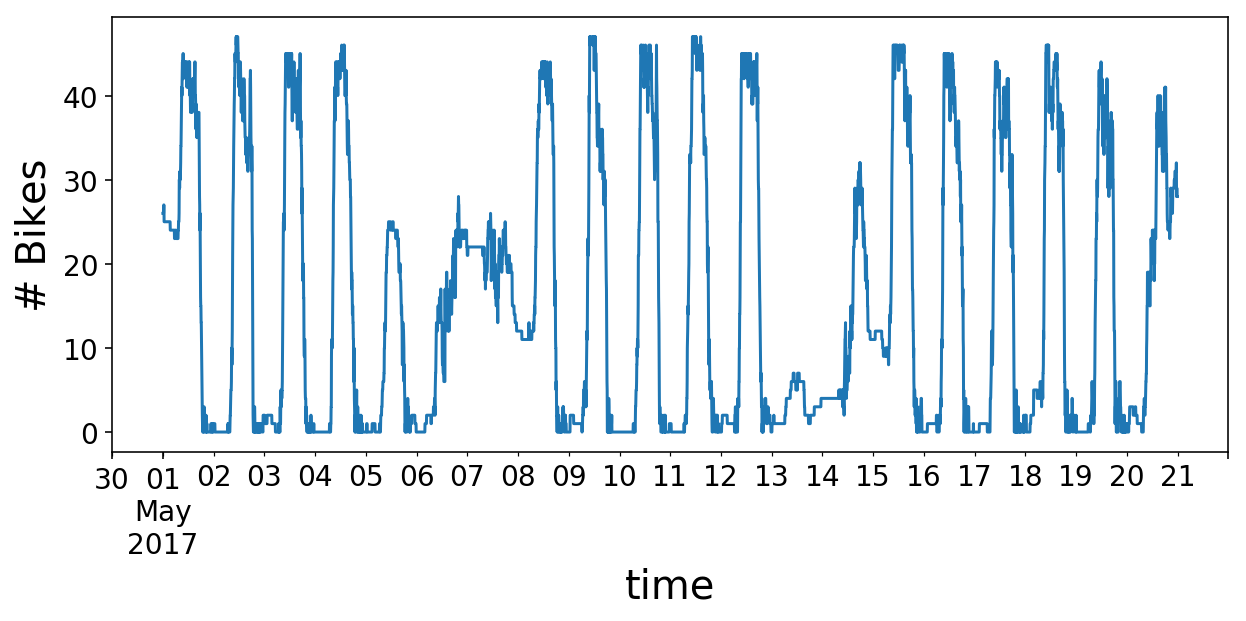

In [3]:
y.loc['2017-05-01':'2017-05-20'].plot(figsize=(10, 4));
plt.ylabel('# Bikes');

In [4]:
# Convert to an array for the rest of the post
y = y.values

### Checking Stationarity

For posterity, let's walk through how to look at the stationarity of the data (like, in the proper way to estimate ARIMA parameters). The common method of checking to see if data is stationary is to plot its autocorrelation function. The autocorrelation involves "sliding" or "shifting" a function and multiplying it with its unshifted self. This allows one to measure the overlap of the function with itself at different points in time. This process ends up being useful for discovering periodicity in ones data. For example, a sine wave repeats itself every $2\pi$, so one would see peaks in the autocorrelation function every $2\pi$. If that's confusing, please check out this great [post](http://qingkaikong.blogspot.com/2017/01/signal-processing-how-autocorrelation.html) which contains an explanatory animation.

We can use [statsmodels](http://www.statsmodels.org) to plot our autocorrelation function. We can use the autocorrelation function to quantify this. Below, I plot three autocorrelations at different numbers of "lags" (the terminology `statsmodels` uses). Our residual samples are 5 minutes apart. Each plot below looks at the autocorrelation going out to some time window or "number of lags". Autocorrelations always start at 1 (a function perfectly overlaps with itself), but we would like to see that it drops down close to zero. These plots show that it certaintly does not!

Notice that the autocorrelation rises as we hit 1-day of periodicity in the second plot. In the third plot, we get daily peaks but an even bigger peak out at the seventh day which corresponds to the weekly periodicity or "seasonality".

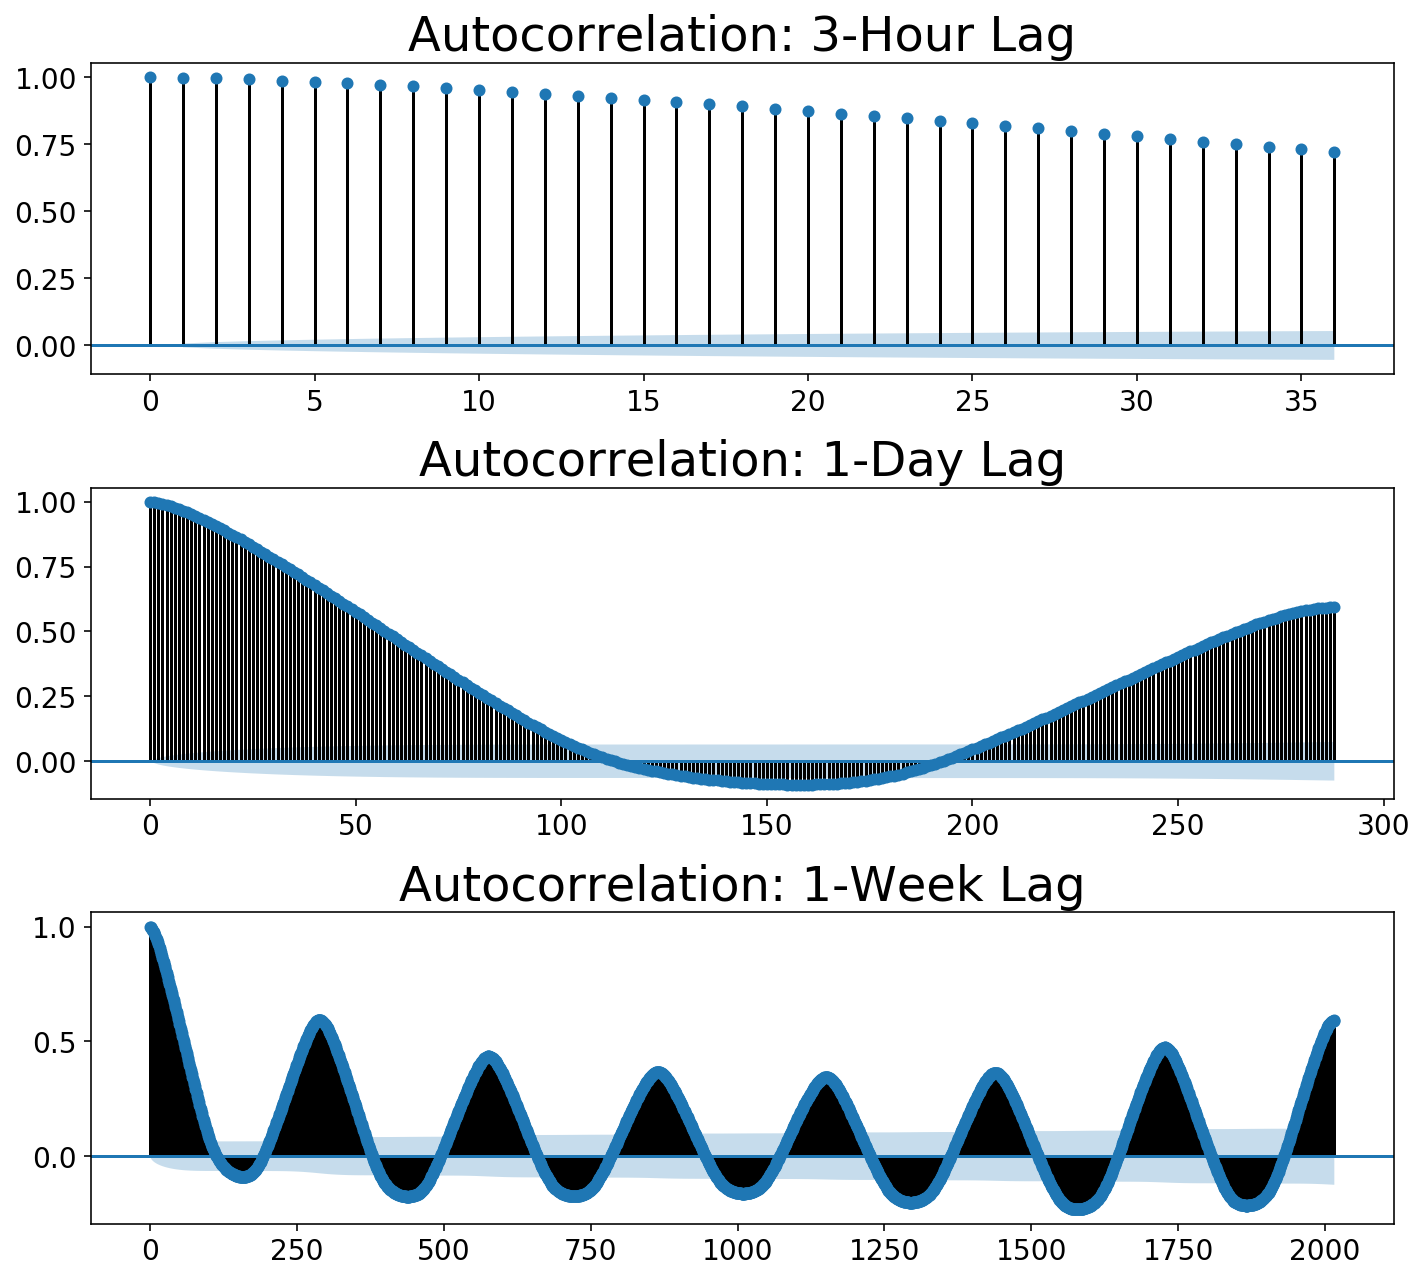

In [5]:
import statsmodels.tsa.api as smt


def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);
    
    fig.tight_layout();

period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
    
lags = [3 * samples_per_hour, samples_per_day, samples_per_week]
titles= ['Autocorrelation: 3-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag']

plot_multi_acf(y, lags, titles)

## Reversible Transformations

So we should probably try differencing our data. That is, we should subtract the adjacent point from each point. This seems like a simple concept. [Lots](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) of [posts](https://tomaugspurger.github.io/modern-7-timeseries) reference the [DataFrame.shift()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) function in pandas as an easy way to subtract shifted data. My neurotic issue was that, once one does this, it is nontrivial to reconstruct the original time series. Consequently, how does one then feed the differenced data through a model and plot the prediction alongside the original data? 

Additionally, one performs regression on the difference time series data in an ARIMA model. This is a unique problem that shows where time series diverge from conventional machine learning via scikit-learn. While one may build and manipulate a bunch of features for an ML prediction, the target values (i.e. $y$) are typically left alone. I, for one, am always scared too touch them lest I leak target information into my features. With time series, though, one must actually transform the `y` variable that is fed into the eventual model `fit(X, y)` method. 

Given the needs that I had - reversible transformations and the ability to modify both `X` and `y` - I ended up building a library that is inspired by scikit-learn (all classes inherit from scikit-learn classes), but there are definitely untoward actions deviating from the scikit-learn paradigm. As mentioned at the top, this library is called `skits`, and can be found on my [github](https://github.com/ethanrosenthal/skits). I should warn that it is definitely a work in progress with a non-stationary API (har har har).

## Why not use an existing library? 

[statsmodels](http://www.statsmodels.org) has a lot of time series models along with plotting and pandas integrations. However, I had difficulty figuring out what was going on under the hood. Also, I did not understand how one would use a trained model on new data. And even if I did figure this out, who the hell knows how you serialize these models? Finally, I like the composability of scikit-learn. If I want to throw a neural network at the end of a pipeline, why shouldn't I be able to?

After I started this post, I found this library [tsfresh](http://tsfresh.readthedocs.io/) which does appear to allow one to build features out of time series and throw them in a scikit-learn pipeline. However, this library does _so many things_ and builds _so many features_, and I could not figure out how to do anything simple with it. It felt like a sledgehammer, and I just needed a tapper. Nonetheless, the library seems extremely powerful, and I would love to play with it given a suitable dataset.

I would like to call out Facebook's [prophet](https://facebook.github.io/prophet/) which seems excellent for understanding uncertainty in time series predictions. Uncertainty in time series is typically quite large (it's hard to predict the future!), so quantifying this is often of paramount importance (think: risk management). I would like to write about this library in a future post.

Lastly, I will talk later about forecasting, but I will say now that I wanted the ability to build models that directly optimize for "multi-step ahead" forecasting which I have not seen widely implemented. 

## Preprocessing with skits

We would like to difference our data and plot the autocorrelation. We can use the `DifferenceTransformer` class in `skits` to difference the data. When we difference the data, we will necessarily create some Null (`np.nan`) values in the data (we cannot subtract the earlier point from the first point in the array). `scikit-learn` does not like Null values, so we will use a `ReversibleImputer` to fill in these values. The other option would be to remove the Null values, but the number of rows in your data never changes in scikit-learn pipelines, and I did not want to deviate from that behavior. Both of these steps occur *before* we end up building machine learning features with the data, so they are in the `skits.preprocessing` module. All classes in `preprocessing` contain `inverse_transform()` methods such that we reconstruct the original time series.

We would like to chain their transformations together, so we will use the `ForecasterPipeline` in `skits.pipeline`. Due to me not figuring out a better way to do this, all preprocessing transformers must prefix their name with `'pre_'`.

In [6]:
from skits.preprocessing import (ReversibleImputer, 
                                 DifferenceTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.preprocessing import StandardScaler

We now construct the pipeline, fit the transformers, and transform the data. Our design matrix, $X$, is just a copy of the $y$ time series, though we must add an extra axis because `scikit-learn` expects 2D design matrices. I end up needing to employ two differencing operations in order to stationarize the residuals. The first is a standard differencing operation between adjacent points. The second differencer handles the seasonality in the data by taking the difference between points separated by a day. We also need a `ReversibleImputer` in between each differencing operation to handle the Null values. A StandardScaler is used at the end to keep the data normalized.

In [7]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler())
])

X = y.copy()[:, np.newaxis]

Xt = pipeline.fit_transform(X, y)

As before, we can plot the autocorrelation functions. You can see that the 3-Hour view shows the autocorrelation immediately dropping to zero, while the daily views show that it takes one day for the autocorrelation to drop to zero.

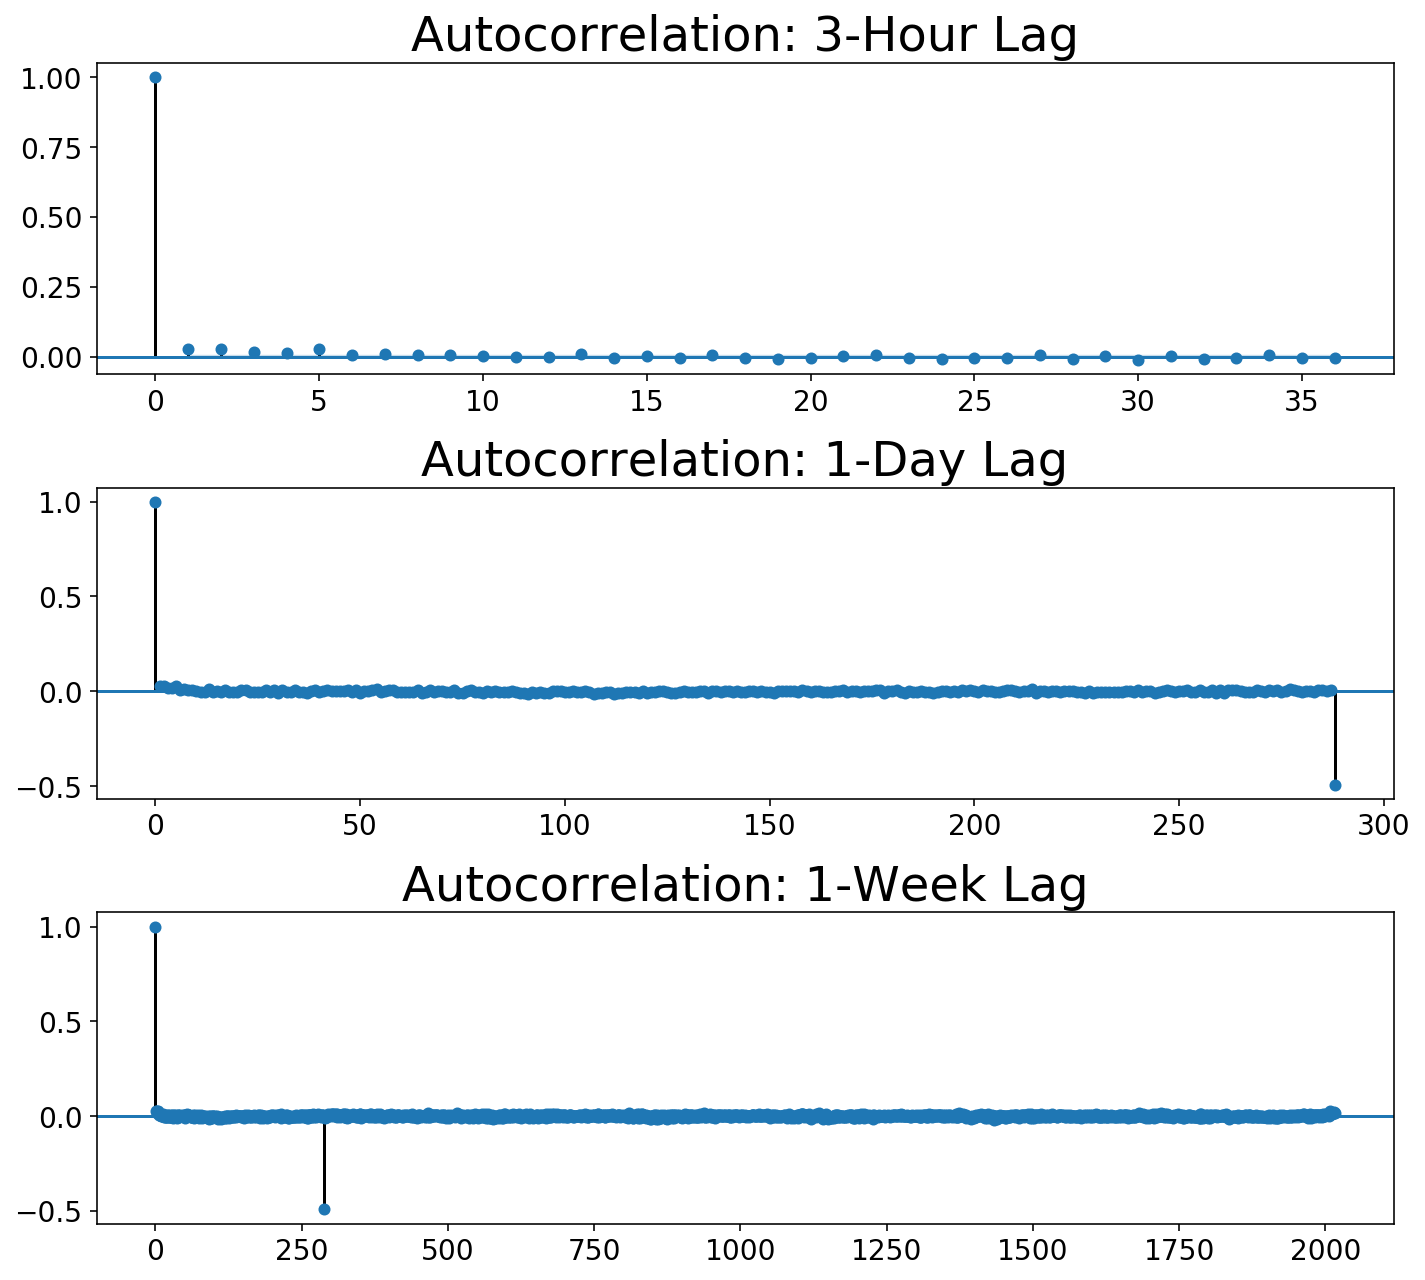

In [8]:
plot_multi_acf(Xt.squeeze(), lags, titles)

The Box-Jenkins method calls for not only looking at the autocorrelation function but also the partial autocorrelation:

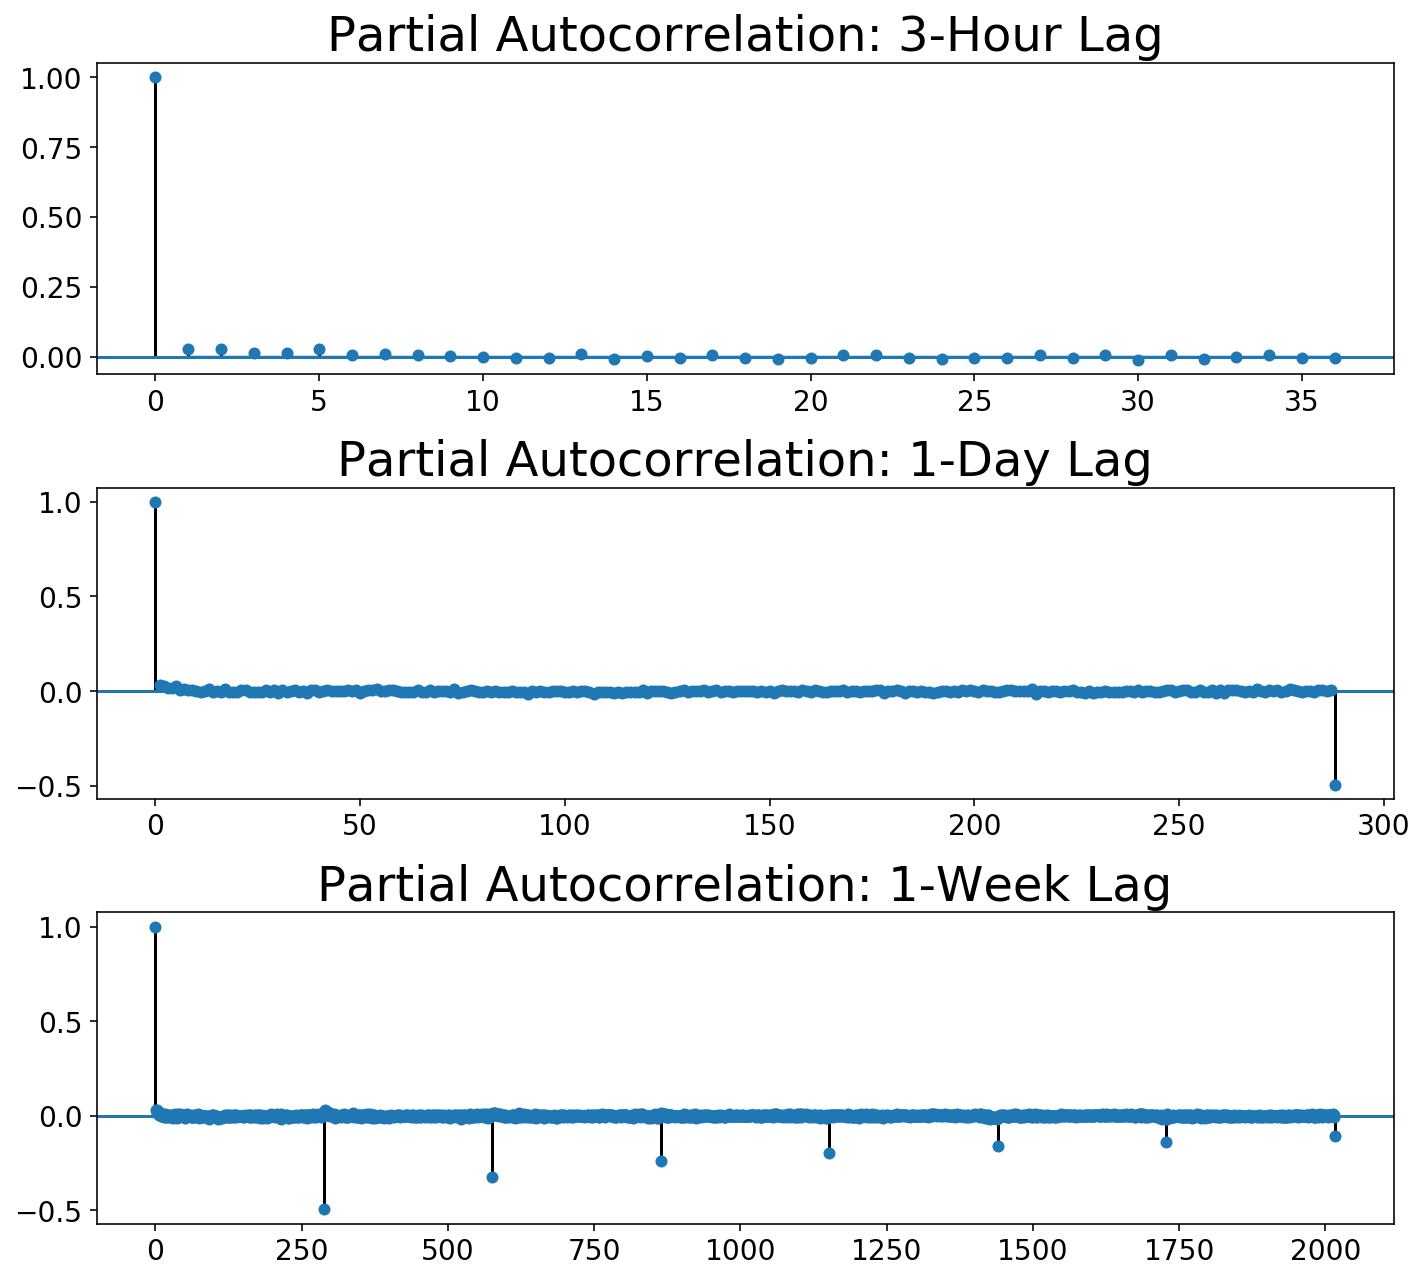

In [9]:
plot_multi_acf(Xt.squeeze(), lags, ['Partial ' + t for t in titles], 
               partial=True)

We can see that, while the autocorrelation drops to zero after one day lag, the partial autocorrelation slowly decays over day lags. As far as I can tell, Box-Jenkins says that this is likely a seasonal moving average model. Unfortunately, we can't do that with our scikit-learn-style framework!

So, let's move on and try modeling this with autogregressive terms so I can at least show you how to model with `skits` :)

## Fitting and Predicting with skits

After preprocessing, we need to build some features and to add on a regression model. We'll create features corresponding to a single autoregressive term and a single seasonal autoregressive term corresponding to a lag of a day. All of these features should be added after the preprocessing steps via a [FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html). We'll use linear regression as our regression model.

In [10]:
from skits.pipeline import ForecasterPipeline
from skits.feature_extraction import (AutoregressiveTransformer,
                                      SeasonalTransformer)

In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              RandomForestRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

In [12]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=samples_per_day)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('post_feature_scaler', StandardScaler()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

We can now plot our predictions alongside the original data. Recall that each "prediction" point is just the predicted value of the time series at that point, given all of the data prior to that point.

Below, we predict the last 1000 points of the series. While the prediction starts off solid, it quickly starts to veer into crazy land containing things like negative available bikes. I have two theories why this happens:

1. We need moving average terms.
1. Differencing operations are very dangerous. In order to invert the `DifferenceTransformer`, we must calculate a cumulative sum. Any small floating point errors will get cumulatively magnified in this process. Coincidentally, this is why numerical integrations are best avoided, and I guess now I'm starting to understand why these are the Integrated terms.

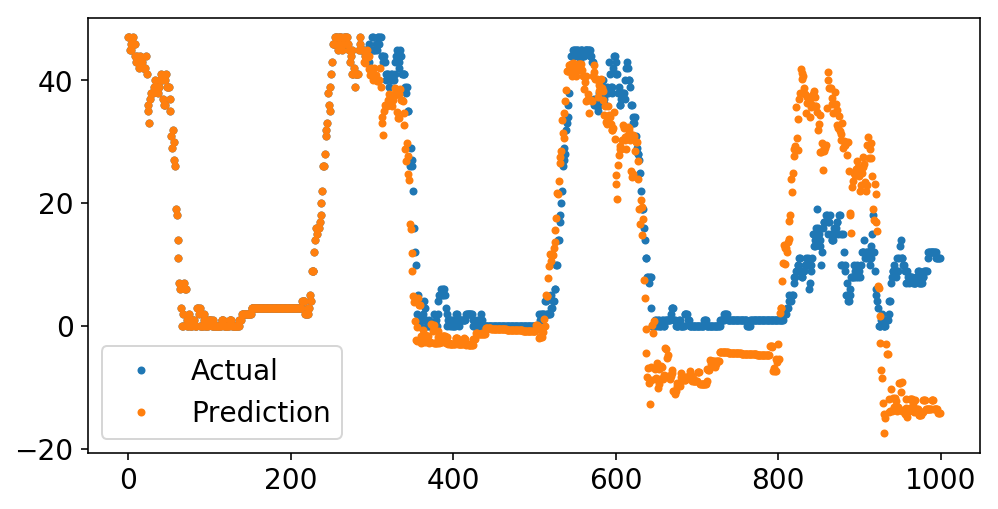

In [13]:
plt.plot(y[-1000:], '.');
plt.plot(pipeline.predict(X[-1000:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

What is terrifying is that I can simplify our pipeline greatly and get an excellent fit.

In [14]:
pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

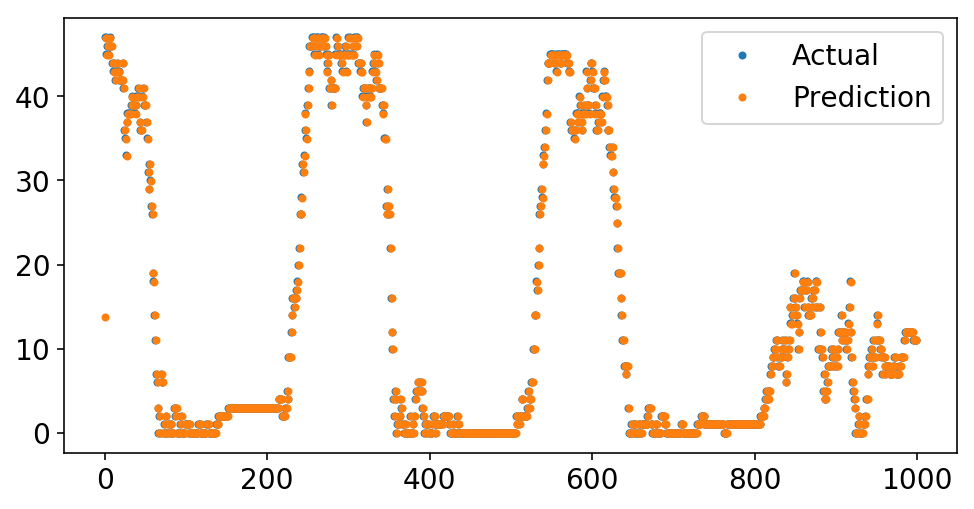

In [15]:
plt.plot(y[-1000:], '.');
plt.plot(pipeline.predict(X[-1000:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

Wow, look at that fit! And all with only a single autoregressive term. What's going on?

We start by taking a look at the coefficient of the single autoregressive term:

In [16]:
print(f'Autoregressive Lag Coefficient = {pipeline.named_steps["regressor"].coef_[0]:4.3f}')

Autoregressive Lag Coefficient = 0.999


It's practically one. That just means that we're predicting that the next value will be the last value. If we look closer at the data, we can see this eye.

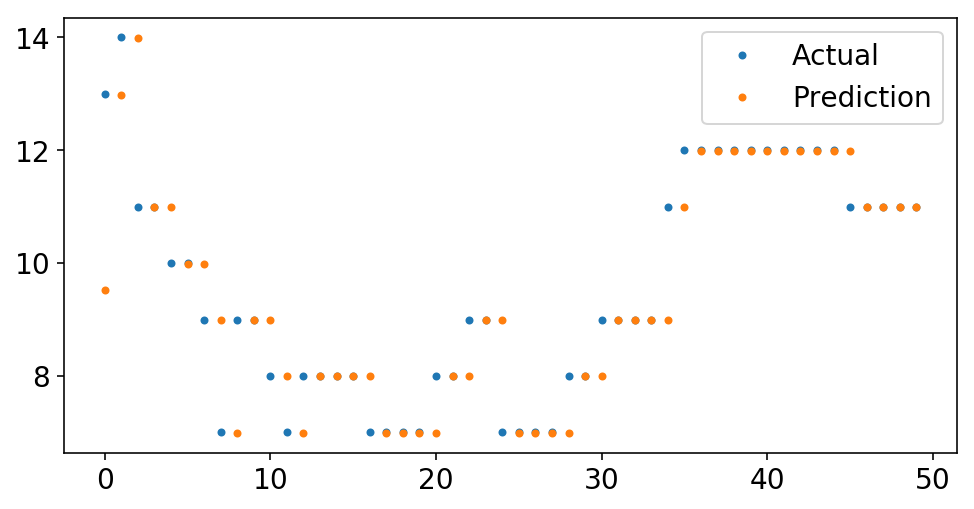

In [17]:
plt.plot(y[-50:], '.');
plt.plot(pipeline.predict(X[-50:], to_scale=True), '.');
plt.legend(['Actual', 'Prediction']);

## Forecasting

For the five-minute sampling period of our data, prediting the last point is the next point is probably a decent guess. But, has our model actually learned anything?

On one hand, if we want to correctly guess the number of bikes available in the next five minutes, we are going to be pretty accurate:

In [18]:
mse = mean_squared_error(y, pipeline.predict(X, to_scale=True))
rmse = np.sqrt(mse)
print(f'RMSE = {rmse:4.2f}')

RMSE = 1.13


On the other hand, if we were to feed our model's prediction as the next point in the series and continue to make predictions off the model predictions, our predictions would never change. If the past = the future, then why should anything change? This the so called out of sample forecasting. We can actually do this with `skits` using the `forecast` method. We run in-sample predictions up until the `start_idx`, and then we start forecasting.

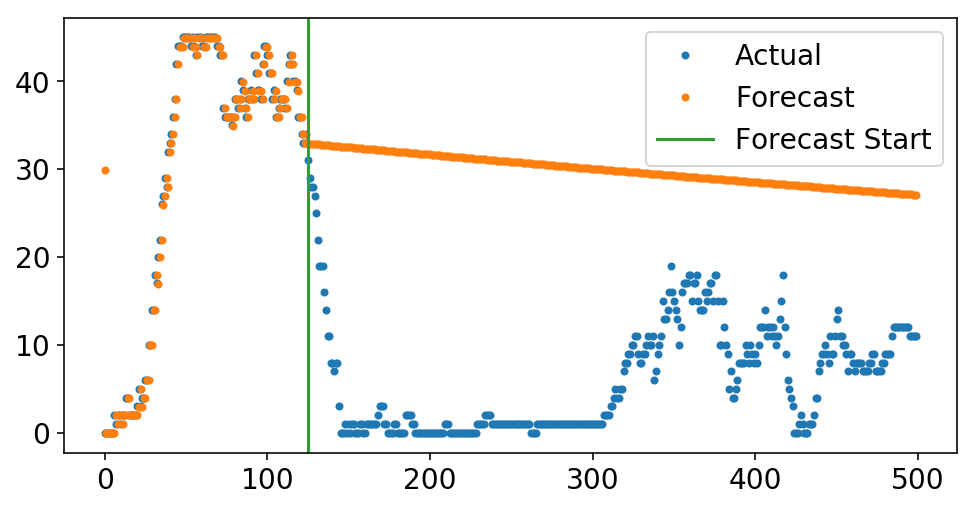

In [19]:
start_idx = 125

plt.plot(y[-500:], '.');
plt.plot(pipeline.forecast(X[-500:, :], start_idx=start_idx), '.');

ax = plt.gca();
ylim = ax.get_ylim();
plt.plot((start_idx, start_idx), ylim);
plt.ylim(ylim);
plt.legend(['Actual', 'Forecast', 'Forecast Start']);

The above is my attempt to illuminate why simple ARIMA models can be helpful - I _knew_ what the forecast would look like before I even plotted it. Knowing how a deterministic process will play out is, like, the foundation of lots of science. However, when I think of these models from the machine learning side, they seem silly. If you want your model to forecast well, then why not bake that into your loss function and actually optimize for this? That, my friends, will have to wait for the next post.

## Time Series Classification

I set out to learn about time series so that I could know if there would be docks available at a future point in time at a Citi Bike station. After all my waxing and waning above, let's get back to the real world and apply our knowledge.

For simplicity, let's solve the problem of predicting whether there will be any bikes available at the station. I don't care exactly how many bikes are at the station - I just want to know if there will be _any_. We can thus cast this as a classification problem. I will keep my original `X` matrix containing the number of bikes, but I will turn the `y` array into a binary indicator of whether or not there are any bikes. We have a reasonable amount of class imbalance, which is good - there are often bikes!

In [20]:
y = y > 0

In [21]:
print(y.mean())

0.8709889903077068


`skits` contains a `ClassificationPipeline` which allows one to add on a classification model at the end. One can also control how many steps out in the future they want to predict. Let's say that I am 15 minutes away from a station. We'll try to predict if there will be bikes 15 minutes from now, which corresponds to 3 data points in the future. This term must be included in all of the feature transformers that rely on previous values of the data via the `pred_stride` term.

In [22]:
from skits.pipeline import ClassifierPipeline
from sklearn.linear_model import LogisticRegression

In [23]:
pipeline = ClassifierPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1, pred_stride=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('classifier', LogisticRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y)

In [24]:
y_pred = pipeline.predict_proba(X)[:, 1]

In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
print(f'AUC = {roc_auc_score(y, y_pred):4.2f}')

AUC = 0.98


And so we get amazing AUC with only looking at a single value of the data 15 minutes earlier. We are likely only correctly classifying trivial examples and not getting right the examples that matter (like when the bikes rapidly deplete during rush hour). We can directly visualize this by plotting the true number of bikes alongside the mode's predicted probability of there being at least one bike. What you see is that it looks like a scaled version of our earlier, regression plot. This makes sense, because this is just the earlier plot passed through the sigmoid function of Logisitic Regression.

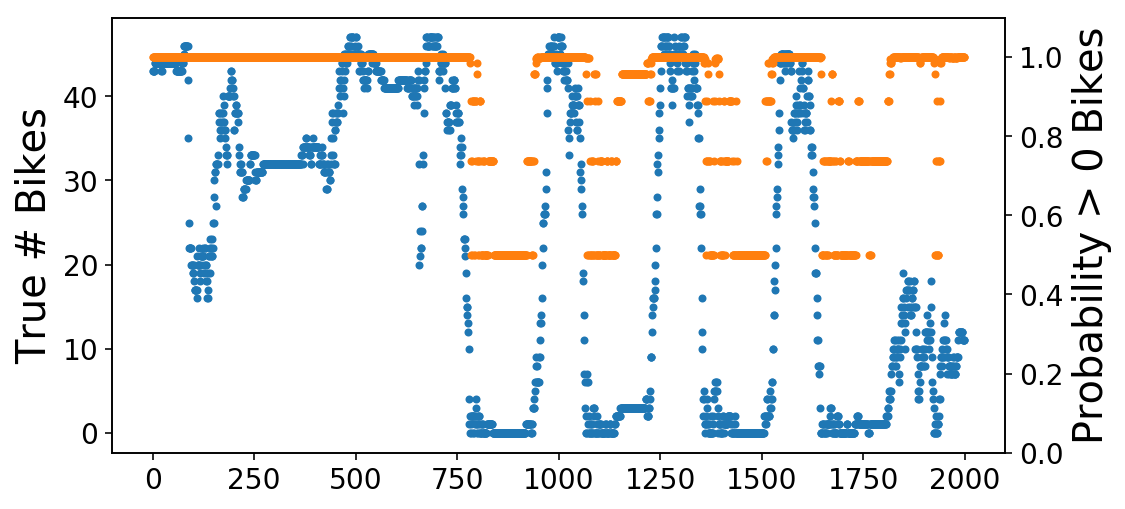

In [27]:
fig, ax = plt.subplots();
ax.plot(X[-2000:, 0], '.');
ax2 = ax.twinx();
ax2.plot(y_pred[-2000:], 
         '.',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));

ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');

We can then zoom in on one of the transitions from available to zero bikes. As you see, the probability (orange) line is slow to react to these changes (though this is admittedly a hard problem).

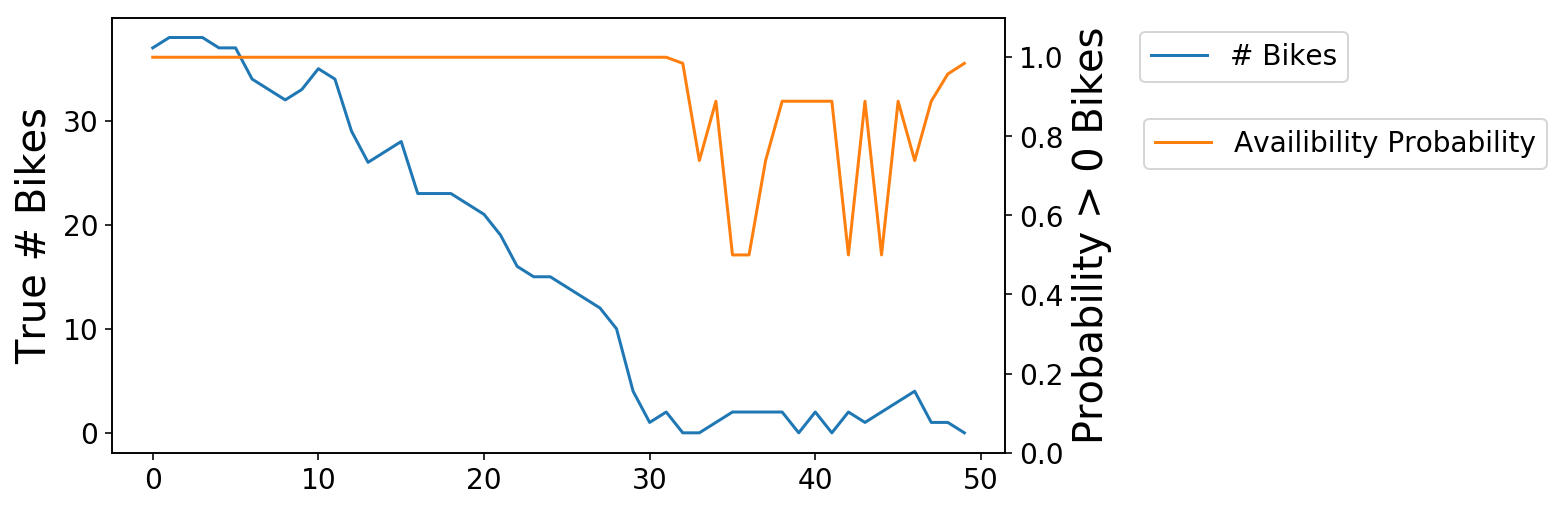

In [28]:
fig, ax = plt.subplots();
ax.plot(X[-1250:-1200], '-');
ax2 = ax.twinx();
ax2.plot(y_pred[-1250:-1200], 
         '-',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));
ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');
ax.legend(['# Bikes'], bbox_to_anchor=(1.4, 1));
ax2.legend(['Availibility Probability'], bbox_to_anchor=(1.14, .8));

We can approach alleviating this problem in two ways - we can build out selective training data to focus on the more important examples, or we can try to build a proper forecasting model such that we can handle both trivial and nontrivial cases. I'll focus on the latter in the next post.